In [1]:
import pandas as pd
import os
import preprocessor as p
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=30)

from src.data.utils import find_emojis, save_to_csv

INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path = '/scratch/czestoch/emoji-tweets-09-2019'
dfs = []
for i in range(28):
    dfs.append(pd.read_parquet(os.path.join(path, f"batch_{i}.parquet")))
df = pd.concat(dfs)
len(df)

1999371

In [17]:
df.head()

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text,emojis,n_emojis
0,59,1168335483987988480,2019-09-02 01:31:00+00:00,en,1158815200461697026,31,42,285,@jaxlively Lmaoooo hunnit this shit leaving me...,[🥴],1
1,62,1168335500773642240,2019-09-02 01:31:04+00:00,en,4888723335,484,712,1900,Got something going through my brain that I ca...,[🤯],1
2,34,1168335509149618176,2019-09-02 01:31:06+00:00,en,235255263,380,303,3197,I can officially say I am DONE 👋🏼😋,"[👋🏼, 😋]",2
3,35,1168335521728385035,2019-09-02 01:31:09+00:00,en,1167118446557106176,86,35,1642,stan marty the coke snorting king 🤩,[🤩],1
4,69,1168335530100187136,2019-09-02 01:31:11+00:00,en,1113229774720253952,52,68,489,Everybody loves zukos nice nice nice funny boy...,"[😌, 😌]",2


In [5]:
df[df.isnull().any(axis=1)]

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text


In [6]:
len(df[df.duplicated()])

3103

In [7]:
df = df.drop_duplicates()

In [8]:
len(df[df.duplicated("text")])

10111

In [9]:
df = df.drop_duplicates("text")

In [10]:
f"{len(df):,}"

'1,986,157'

In [11]:
df.describe()

,n_chars,user_n_followers,user_n_following,user_n_tweets
count,1.986157e+06,1.986157e+06,1.986157e+06,1.986157e+06
mean,7.415728e+01,3.453528e+03,1.123764e+03,2.460607e+04
std,5.966867e+01,8.666231e+04,6.129827e+03,5.871392e+04
min,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.300000e+01,1.430000e+02,1.800000e+02,1.727000e+03
50%,5.400000e+01,4.600000e+02,4.170000e+02,7.728000e+03
75%,9.500000e+01,1.280000e+03,9.220000e+02,2.571500e+04
max,1.083000e+03,2.837179e+07,1.837560e+06,3.775089e+06


In [12]:
df[df.n_chars == 5].text

3271     well😀
5807     This👇
6217     wild😳
7531     Damn😕
8516     okay💍
         ...  
62854    luvv💗
63585    sick😷
69594    scat😔
70186    damn❤
73511    Mood😇
Name: text, Length: 833, dtype: object

In [13]:
df['emojis'] = df.text.parallel_apply(find_emojis)

In [14]:
df['n_emojis'] = df.emojis.parallel_apply(len)

In [15]:
df.head()

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text,emojis,n_emojis
0,59,1168335483987988480,2019-09-02 01:31:00+00:00,en,1158815200461697026,31,42,285,@jaxlively Lmaoooo hunnit this shit leaving me...,[🥴],1
1,62,1168335500773642240,2019-09-02 01:31:04+00:00,en,4888723335,484,712,1900,Got something going through my brain that I ca...,[🤯],1
2,34,1168335509149618176,2019-09-02 01:31:06+00:00,en,235255263,380,303,3197,I can officially say I am DONE 👋🏼😋,"[👋🏼, 😋]",2
3,35,1168335521728385035,2019-09-02 01:31:09+00:00,en,1167118446557106176,86,35,1642,stan marty the coke snorting king 🤩,[🤩],1
4,69,1168335530100187136,2019-09-02 01:31:11+00:00,en,1113229774720253952,52,68,489,Everybody loves zukos nice nice nice funny boy...,"[😌, 😌]",2


In [21]:
from collections import Counter
flatten = lambda t: [item for sublist in t for item in sublist]
emoji_counts = Counter(flatten(df['emojis'].apply(set).tolist()))
df2 = {"emoji": list(emoji_counts.keys()), "count": list(emoji_counts.values())}
df2 = pd.DataFrame.from_records(df2)
df2.head()

context_free_emojis = pd.read_csv("/scratch/czestoch/emoji-measures/ambiguity_variation.csv.gz").emoji
context_free_emojis

df2 = df2[df2.emoji.isin(context_free_emojis.tolist())]

save_to_csv(df2, "/scratch/czestoch/emoji-measures/twitter-stream-09-2019-context-free-emoji-counts.csv")

,count,emoji
0,26410,🥴
1,4942,🤯
2,9034,😋
3,458,👋🏼
4,11051,🤩


In [13]:
f"{len(df[df.n_emojis == 1]):,}"

'1,111,288'

In [14]:
#Choose only tweets with one emoji
df = df[df.n_emojis == 1]

In [15]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG)
p.clean(df.iloc[0].text)

'Lmaoooo hunnit this shit leaving me so confused🥴'

In [16]:
df["cleaned_text"] = df.text.parallel_apply(lambda x: p.clean(x))

In [17]:
df = df.drop("n_emojis", axis=1)

In [18]:
df.emojis = df.emojis.parallel_apply(lambda x: x[0])

In [19]:
tweets_per_emoji = df.groupby("emojis").text.count()

In [20]:
tweets_per_emoji.describe()

count      2581.000000
mean        430.564897
std        3281.507798
min           1.000000
25%           3.000000
50%          11.000000
75%          55.000000
max      125622.000000
Name: text, dtype: float64

In [21]:
tweets_per_emoji[tweets_per_emoji == tweets_per_emoji.max()]

emojis
😂    125622
Name: text, dtype: int64

In [22]:
tweets_per_emoji[tweets_per_emoji == tweets_per_emoji.min()]

emojis
*⃣     1
*️⃣    1
5⃣     1
↕️     1
↖      1
      ..
🧟‍♀    1
🧧      1
🧫      1
🧰      1
🪔      1
Name: text, Length: 365, dtype: int64

In [23]:
# Choose tweets with emojis that appeared in at least 30 different tweets
# df = df[df.emojis.isin(tweets_per_emoji[tweets_per_emoji >= 30].index)]

In [24]:
#f"{len(df):,}"

In [25]:
df.emojis.nunique()

2581

In [26]:
dir_path = "/scratch/czestoch/emoji-measures/"
context_free_emojis = pd.read_csv(os.path.join(dir_path, "ambiguity_variation.csv.gz"))["emoji"]

In [27]:
df = df[df.emojis.isin(context_free_emojis)]
print(f"{len(df):,}")
df.emojis.nunique()

978,017


1207

In [28]:
df.to_parquet('/scratch/czestoch/cleaned_english_emoji_tweets_2019_09.parquet.gzip', compression='gzip')

In [29]:
########################################################################################

In [5]:
print("Loading data...")
path = "/scratch/czestoch/emoji-measures-input/cleaned_english_emoji_tweets_2019_09.parquet.gzip"
tweets = pd.read_parquet(path)[["cleaned_text", "emojis"]]
tweets = tweets.rename({"cleaned_text": "tweet"}, axis=1)
tweets.head()

Loading data...


,tweet,emojis
0,Lmaoooo hunnit this shit leaving me so confused🥴,🥴
1,Got something going through my brain that I ca...,🤯
3,stan marty the coke snorting king 🤩,🤩
8,unfollow 🤭,🤭
10,Please do if it’s not too much trouble!! 😊,😊


In [6]:
df1 = tweets.groupby("emojis").tweet.count()
df1 = df1.to_frame().reset_index()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : True})

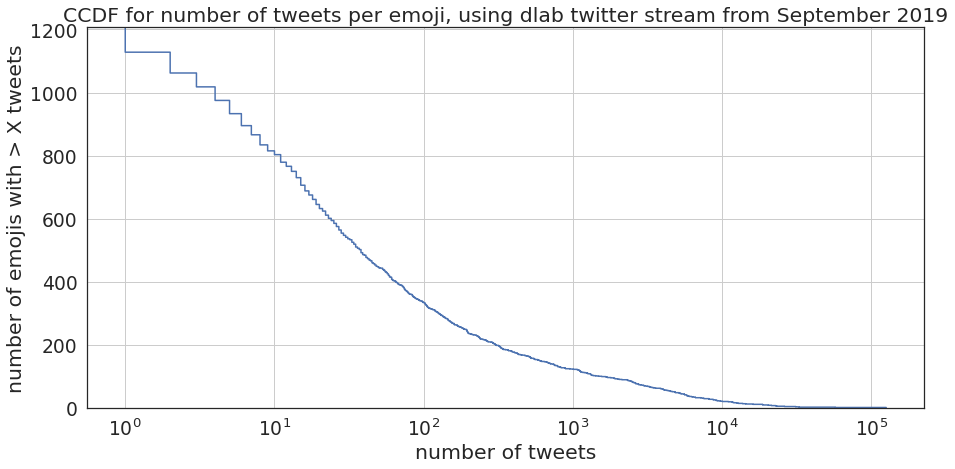

In [8]:
fig, ax = plt.subplots()
ax = sns.ecdfplot(data=df1, x="tweet", stat='count', complementary=True, ax=ax)
ax.set_title("CCDF for number of tweets per emoji, using dlab twitter stream from September 2019")
ax.set_xscale("log")
ax.set_xlabel("number of tweets")
ax.set_ylabel("number of emojis with > X tweets");

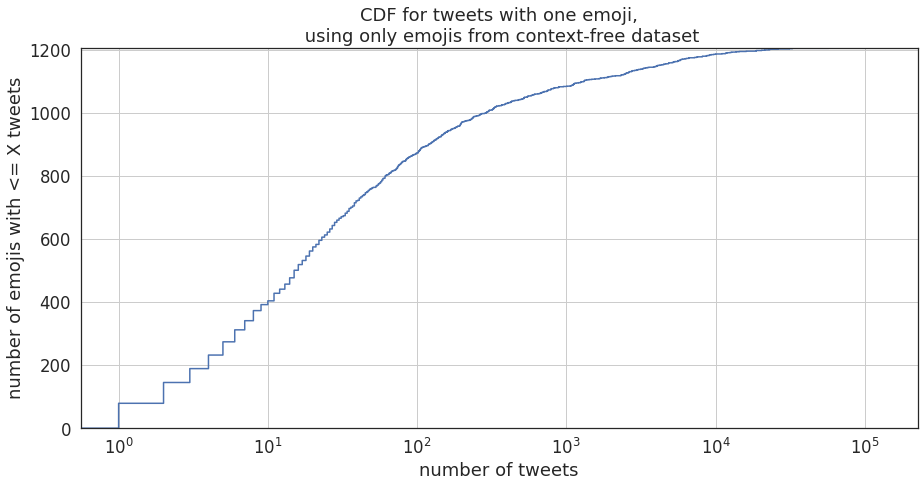

In [46]:
fig, ax = plt.subplots()
ax = sns.ecdfplot(data=df1, x="tweet", stat='count', ax=ax)
ax.set_title("CDF for tweets with one emoji,\n using only emojis from context-free dataset")
ax.set_xscale("log")
ax.set_xlabel("number of tweets")
ax.set_ylabel("number of emojis with <= X tweets");

In [35]:
len(df1[df1.tweet >= 100])

334

In [36]:
len(df1[df1.tweet >= 30])

547

In [41]:
df1[df1.tweet >= 100].emojis.values

array(['‼️', '⁉️', '™️', '☀️', '☁️', '☑️', '☔', '☕', '☘️', '☝️', '☠️',
       '☹️', '☺️', '♥️', '⚔️', '⚜️', '⚠️', '⚡', '⚽', '⚾', '✅', '✈️', '✊',
       '✋', '✌️', '✍️', '✔️', '✨', '❄️', '❌', '❓', '❗', '❣️', '❤️', '➡️',
       '⬆️', '⬇️', '⭐', '🅱️', '🌈', '🌊', '🌍', '🌎', '🌙', '🌚', '🌝', '🌞', '🌟',
       '🌱', '🌴', '🌷', '🌸', '🌹', '🌺', '🌻', '🌼', '🌿', '🍀', '🍁', '🍂', '🍃',
       '🍆', '🍊', '🍎', '🍑', '🍒', '🍔', '🍕', '🍪', '🍰', '🍵', '🍷', '🍺', '🍻',
       '🍾', '🍿', '🎁', '🎂', '🎃', '🎈', '🎉', '🎊', '🎤', '🎥', '🎧', '🎨', '🎬',
       '🎭', '🎯', '🎵', '🎶', '🎼', '🎾', '🏀', '🏃', '🏆', '🏈', '🏉', '🏐',
       '🏳️\u200d🌈',
       '🏴\U000e0067\U000e0062\U000e0073\U000e0063\U000e0074\U000e007f',
       '🐀', '🐈', '🐍', '🐐', '🐕', '🐝', '🐢', '🐦', '🐯', '🐰', '🐱', '🐶', '🐷',
       '🐸', '🐺', '🐻', '🐾', '👀', '👅', '👆', '👇', '👉', '👊', '👋', '👌', '👍',
       '👎', '👏', '👐', '👑', '👩\u200d❤️\u200d💋\u200d👩', '👶', '👹', '👺', '👻',
       '👽', '👿', '💀', '💁', '💃', '💅', '💉', '💋', '💌', '💍', '💎', '💐', '💓',
       '💔', '💕', '💖', '💗', '💘', '💙', '💚',

In [42]:
df1[df1.tweet >= 30].emojis.values

array(['©️', '‼️', '⁉️', '™️', '⌚', '⏰', '⏳', '▶️', '☀️', '☁️', '☄️',
       '☎️', '☑️', '☔', '☕', '☘️', '☝️', '☠️', '☢️', '☮️', '☹️', '☺️',
       '♈', '♋', '♍', '♎', '♠️', '♥️', '♻️', '⚓', '⚔️', '⚖️', '⚜️', '⚠️',
       '⚡', '⚫', '⚰️', '⚽', '⚾', '⛅', '⛳', '⛽', '✂️', '✅', '✈️', '✊', '✋',
       '✌️', '✍️', '✏️', '✔️', '✝️', '✨', '❄️', '❌', '❓', '❕', '❗', '❣️',
       '❤️', '➡️', '⤵️', '⬆️', '⬇️', '⭐', '⭕', '🃏', '🅱️', '🅿️', '🆗', '🆘',
       '🌀', '🌃', '🌄', '🌅', '🌈', '🌊', '🌋', '🌌', '🌍', '🌎', '🌏', '🌐', '🌕',
       '🌙', '🌚', '🌛', '🌝', '🌞', '🌟', '🌠', '🌮', '🌯', '🌱', '🌲', '🌳', '🌴',
       '🌵', '🌷', '🌸', '🌹', '🌺', '🌻', '🌼', '🌽', '🌾', '🌿', '🍀', '🍁', '🍂',
       '🍃', '🍄', '🍅', '🍆', '🍇', '🍉', '🍊', '🍋', '🍌', '🍍', '🍎', '🍏', '🍑',
       '🍒', '🍓', '🍔', '🍕', '🍗', '🍜', '🍝', '🍞', '🍟', '🍣', '🍦', '🍩', '🍪',
       '🍫', '🍬', '🍭', '🍯', '🍰', '🍳', '🍴', '🍵', '🍷', '🍸', '🍹', '🍺', '🍻',
       '🍼', '🍾', '🍿', '🎀', '🎁', '🎂', '🎃', '🎄', '🎈', '🎉', '🎊', '🎒', '🎓',
       '🎣', '🎤', '🎥', '🎧', '🎨', '🎩', '🎪', '🎫', '🎬', '🎭', '

In [51]:
tweets = tweets[tweets.emojis.isin(df1[df1.tweet >= 30].emojis.values)]

In [52]:
equalized = tweets.groupby("emojis").sample(n=30, replace=False).reset_index()
equalized.head()

,index,tweet,emojis
0,31666,Music’s gonna save our souls.©️,©️
1,13435,This drawing actually started as a building......,©️
2,47682,"I'd like to say yes, but.... ©️",©️
3,41559,“So Hard To Be Real” Watching you sleep I can’...,©️
4,2325,Brockhampton are undeniably The Best Boyband S...,©️


In [54]:
equalized.emojis.nunique()

547

In [55]:
save_to_csv(equalized[["tweet", "emojis"]], "/scratch/czestoch/cleaned_equalized_september_tweets.csv")